# Imports

In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_8146/2174054843.py:8: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
%%R
# library(tidyverse)
library(dyno)

Loading required package: dynfeature
Loading required package: dynguidelines
Loading required package: dynmethods
Loading required package: dynplot
Loading required package: dynwrap
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


# Loading Data

In [4]:
%%R
data <- readRDS("mesoderm-development_loh (1).rds")
str(data)

List of 21
 $ id                   : chr "real/gold/mesoderm-development_loh"
 $ cell_ids             : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
 $ cell_info            :'data.frame':	504 obs. of  4 variables:
  ..$ cell_id     : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
  ..$ Run         : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
  ..$ LibraryName : chr [1:504] "H7hESC" "H7hESC" "H7hESC" "H7hESC" ...
  ..$ milestone_id: chr [1:504] "H7hESC" "H7hESC" "H7hESC" "H7hESC" ...
 $ source               : chr "real/gold"
 $ normalisation_info   :List of 3
  ..$ has_spike          : logi TRUE
  ..$ has_mito           : logi TRUE
  ..$ normalisation_steps: tibble [6 × 3] (S3: tbl_df/tbl/data.frame)
  .. ..$ type     : chr [1:6] "original" "cell_quality_filtering" "feature_expression_filtering" "normalisation" ...
  .. ..$ nfeatures: int [1:6] 58480 58480 36347 36347 8772 8772
  .. ..$ ncells   : int [1:6] 651 504 504

In [5]:
%%R
data$normalisation_info

$has_spike
[1] TRUE

$has_mito
[1] TRUE

$normalisation_steps
# A tibble: 6 × 3
  type                          nfeatures ncells
  <chr>                             <int>  <int>
1 original                          58480    651
2 cell_quality_filtering            58480    504
3 feature_expression_filtering      36347    504
4 normalisation                     36347    504
5 feature_variability_filtering      8772    504
6 final_filtering                    8772    504



In [6]:
%%R
counts <- data$counts
expression <- data$expression

In [7]:
%%R
dataset <- wrap_expression(
  expression = expression,
  counts = counts
)

In [8]:
%%R
names(data$prior_information)

 [1] "start_milestones"      "start_id"              "end_milestones"       
 [4] "end_id"                "groups_id"             "groups_network"       
 [7] "features_id"           "groups_n"              "timecourse_continuous"
[10] "timecourse_discrete"   "start_n"               "end_n"                


In [9]:
%%R --o grouping
print(data$prior_information$start_id)
print(data$prior_information$start_milestones)
grouping <- data$grouping
# grouping <- ifelse(grouping == "H7hESC", "H7hESC", "temp")
# grouping <- ifelse(names(grouping) == "SRR3952356", "start", "temp")
str(grouping)

[1] "SRR3952356"
[1] "H7hESC"
 Named chr [1:504] "H7hESC" "H7hESC" "H7hESC" "H7hESC" "H7hESC" "H7hESC" ...
 - attr(*, "names")= chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...


In [10]:
pd.Series(grouping).value_counts()

H7_dreived_D2.25_Smtmrs     84
H7_derived_DLL1pPXM         73
H7_derived_Sclrtm           62
H7_derived_APS              62
H7_derived_D5CntrlDrmmtm    59
H7hESC                      54
H7_derived_D2LtM            48
H7_derived_ESMT             40
H7_derived_MPS              22
Name: count, dtype: int64

In [11]:
%%R
data$prior_information$end_id

[1] "SRR3952713" "SRR3952690" "SRR3952891"


In [12]:
%%R
dataset <- add_prior_information(
    dataset,
    start_id = data$prior_information$start_id,
    end_id = data$prior_information$end_id,
    groups_id = data$prior_information$groups_id,
    end_n = data$prior_information$end_n,
)
dataset <- add_grouping(
    dataset,
    data$grouping
)

In [13]:
%%R
print(dataset$prior_information)

$start_id
[1] "SRR3952356"

$end_id
[1] "SRR3952713" "SRR3952690" "SRR3952891"

$groups_id
# A tibble: 504 × 2
   cell_id    group_id
   <chr>      <chr>   
 1 SRR3952323 H7hESC  
 2 SRR3952325 H7hESC  
 3 SRR3952326 H7hESC  
 4 SRR3952327 H7hESC  
 5 SRR3952328 H7hESC  
 6 SRR3952329 H7hESC  
 7 SRR3952330 H7hESC  
 8 SRR3952331 H7hESC  
 9 SRR3952337 H7hESC  
10 SRR3952341 H7hESC  
# ℹ 494 more rows
# ℹ Use `print(n = ...)` to see more rows

$end_n
[1] 3



# Working Models - Scorpius, Angle, PAGA, PAGA Tree, MST, DPT, Component1, Matcher

# Scorpius

In [16]:
%%R
scorpius_model <- infer_trajectory(dataset, ti_scorpius(), give_priors = c("start_id"))

Following packages have to be installed: SCORPIUS
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'SCORPIUS' from a github remote, the SHA1 (a0a97907) has not changed since last install.
  Use `force = TRUE` to force installation


Coloring by grouping


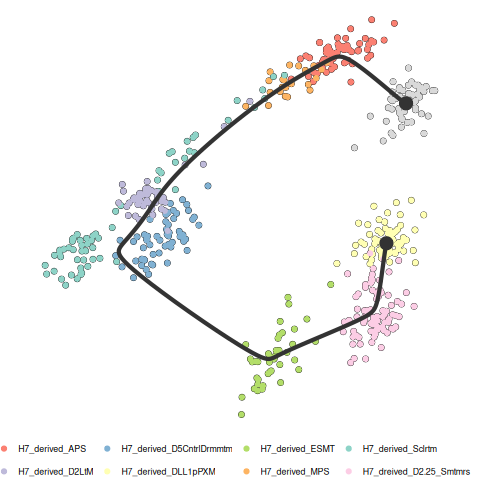

In [18]:
%%R
plot_dimred(scorpius_model, grouping=grouping)

# PAGA

In [20]:
%%R
paga_model <- infer_trajectory(dataset, ti_paga(), give_priors = c("start_id","end_id","groups_id"))

Coloring by grouping


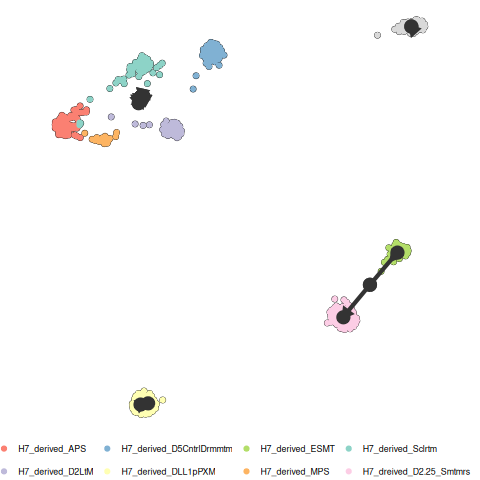

In [21]:
%%R
plot_dimred(paga_model, grouping=grouping)

# Angle

In [22]:
%%R
angle_model <- infer_trajectory(dataset, ti_angle(), give_priors = c("start_id"))

Coloring by grouping


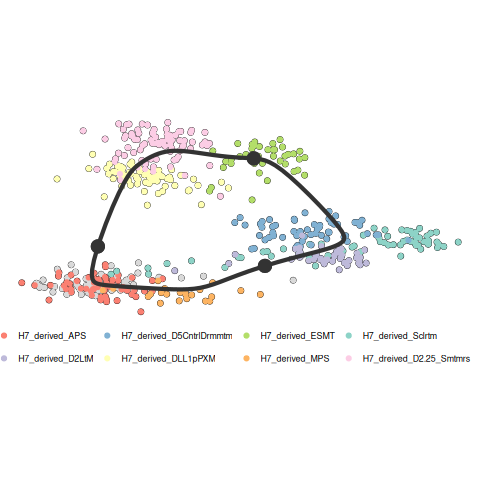

In [23]:
%%R
plot_dimred(angle_model, grouping=grouping)

# PAGA Tree

In [24]:
%%R
paga_tree_model <- infer_trajectory(dataset, ti_paga_tree(), give_priors = c("start_id"))

Coloring by grouping


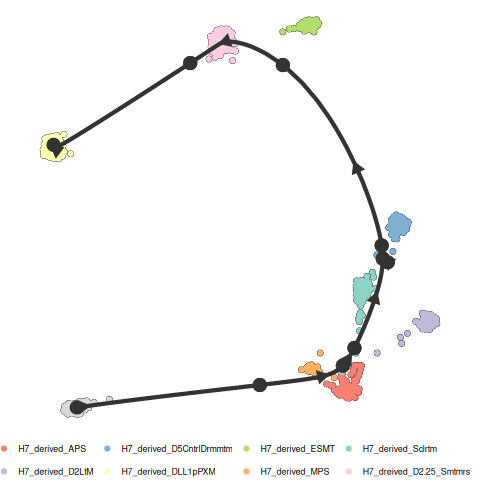

In [25]:
%%R
plot_dimred(paga_tree_model, grouping=grouping)

# MST

In [29]:
%%R
mst_model <- infer_trajectory(dataset, ti_mst(), give_priors = c("start_id"))

Coloring by grouping


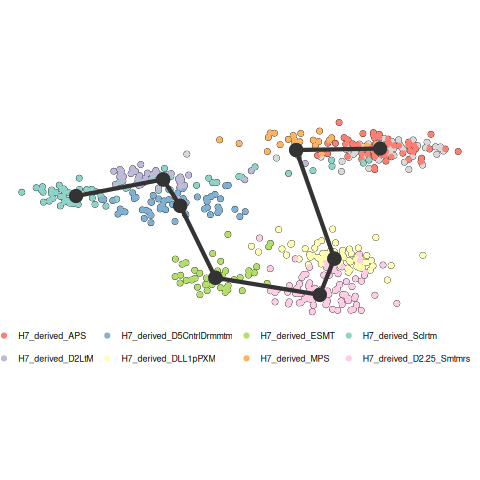

In [30]:
%%R
plot_dimred(mst_model, grouping=grouping)

# DPT

In [38]:
%%R
dpt_model <- infer_trajectory(dataset, ti_dpt(), give_priors = c("start_id"))

Coloring by grouping


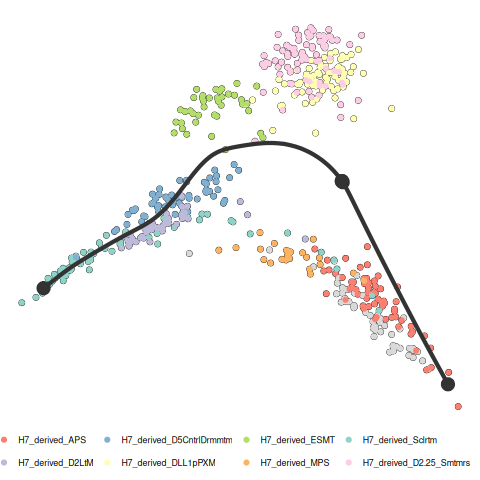

In [39]:
%%R
plot_dimred(dpt_model, grouping=grouping)

# Component1

In [40]:
%%R
comp1_model <- infer_trajectory(dataset, ti_comp1(), give_priors = c("start_id"))

Coloring by grouping


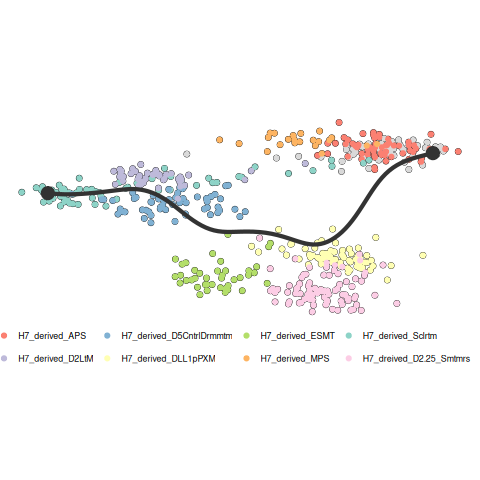

In [41]:
%%R
plot_dimred(comp1_model, grouping=grouping)

# Matcher

In [42]:
%%R
matcher_model <- infer_trajectory(dataset, ti_matcher(), give_priors = c("start_id"))

Coloring by grouping


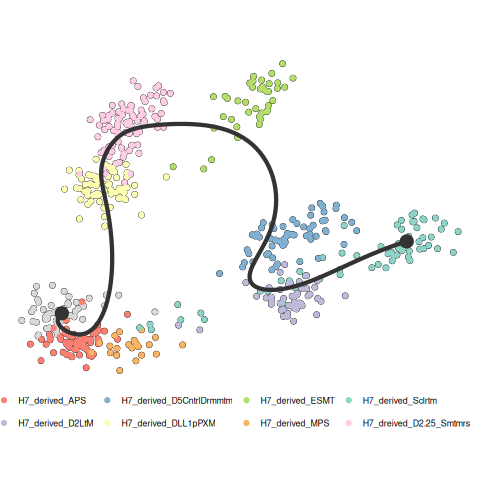

In [44]:
%%R
plot_dimred(matcher_model, expression=data$expression, grouping=grouping)

In [ ]:
%%R
names(data$prior_information)

In [ ]:
%%R
mfa_model <- infer_trajectory(dataset, ti_mfa(), give_priors = c("start_id","end_n"))

In [ ]:
%%R
plot_dimred(mfa_model, expression=data$expression, grouping=grouping)

In [ ]:
%%R
gpfates_model <- infer_trajectory(dataset, ti_gpfates(), give_priors = c("start_id"))

v0.9.9.01: Pulling from dynverse/ti_gpfates
844c33c7e6ea: Already exists
4f11e4e30170: Already exists
a9724dff2655: Already exists
f5f3a048c9c3: Already exists
a53c4db932de: Already exists
bd5da474b8ba: Already exists
be9b916e18e7: Already exists
b8b469f67972: Already exists
e33132a1a81b: Already exists
32bd550d2fc1: Already exists
a828ddf00b38: Already exists
d97023e2f782: Already exists
2cbdcd87b58f: Already exists
51ee6f464655: Already exists
50116fa0c9b6: Already exists
637660a9ca4f: Already exists
e84e980d416e: Already exists
396ed4d9649b: Already exists
3b4e50657540: Already exists
73aee8fff251: Pulling fs layer
4e884cf85e82: Pulling fs layer
39d674b1bb88: Pulling fs layer
da19bf4a0d9c: Pulling fs layer
da19bf4a0d9c: Waiting
4e884cf85e82: Verifying Checksum
4e884cf85e82: Download complete
39d674b1bb88: Download complete
da19bf4a0d9c: Verifying Checksum
da19bf4a0d9c: Download complete
73aee8fff251: Verifying Checksum
73aee8fff251: Download complete
73aee8fff251: Pull complete
4e88

In [ ]:
%%R
plot_dimred(gpfates_model, expression=data$expression, grouping=grouping)

# Other Models

In [15]:
%%R
slingshot_model <- infer_trajectory(dataset, ti_slingshot(), give_priors = c("start_id"))

These packages have more recent versions available.
It is recommended to update all of them.
Which would you like to update?

1: All                       
2: CRAN packages only        
3: None                      
4: ps (1.8.1 -> 1.9.0) [CRAN]



Enter one or more numbers, or an empty line to skip updates:  


Cloning into '/tmp/RtmpGwom4l/file2aaa76fd4a49'...
* installing *source* package ‘S4Vectors’ ...
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0’


gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -fno-omit-frame-pointer -mno-omit-leaf-frame-pointer -ffile-prefix-map=/build/r-base-4sITk6/r-base-4.4.2=. -fstack-protector-strong -fstack-clash-protection -Wformat -Werror=format-security -fcf-protection -fdebug-prefix-map=/build/r-base-4sITk6/r-base-4.4.2=/usr/src/r-base-4.4.2-1.2404.0 -Wdate-time -D_FORTIFY_SOURCE=3  -c AEbufs.c -o AEbufs.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -fno-omit-frame-pointer -mno-omit-leaf-frame-pointer -ffile-prefix-map=/build/r-base-4sITk6/r-base-4.4.2=. -fstack-protector-strong -fstack-clash-protection -Wformat -Werror=format-security -fcf-protection -fdebug-prefix-map=/build/r-base-4sITk6/r-base-4.4.2=/usr/src/r-base-4.4.2-1.2404.0 -Wdate-time -D_FORTIFY_SOURCE=3  -c DataFrame_class.c -o DataFrame_class.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -fno-omit-frame-pointer -mno-omit-leaf-frame-pointer -ffile-prefix-map=/build/r-base-4sITk6/r-base-4.4.2=. -fstack

Rle_class.c: In function ‘_subset_Rle_by_ranges’:
Rle_class.c:1136:17: error: format not a string literal and no format arguments [-Werror=format-security]
 1136 |                 error(errmsg);
      |                 ^~~~~
Rle_class.c: In function ‘_subset_Rle_by_positions’:
Rle_class.c:1161:17: error: format not a string literal and no format arguments [-Werror=format-security]
 1161 |                 error(errmsg);
      |                 ^~~~~
Rle_class.c: In function ‘Rle_extract_range’:
Rle_class.c:1190:17: error: format not a string literal and no format arguments [-Werror=format-security]
 1190 |                 error(errmsg);
      |                 ^~~~~
cc1: some warnings being treated as errors
make: *** [/usr/lib/R/etc/Makeconf:195: Rle_class.o] Error 1
ERROR: compilation failed for package ‘S4Vectors’
* removing ‘/home/satwik/R/x86_64-pc-linux-gnu-library/4.4/S4Vectors’
ERROR: dependency ‘S4Vectors’ is not available for package ‘IRanges’
* removing ‘/home/satwik/R/x86_64

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpGwom4l/file2aaa76fd4a49/DESCRIPTION’ ... OK
* preparing ‘slingshot’:
 OKhecking DESCRIPTION meta-information ...


ERROR: dependencies ‘SummarizedExperiment’, ‘S4Vectors’, ‘GenomicRanges’, ‘DelayedArray’ are not available for package ‘SingleCellExperiment’
* removing ‘/home/satwik/R/x86_64-pc-linux-gnu-library/4.4/SingleCellExperiment’


* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* looking to see if a ‘data/datalist’ file should be added
* building ‘slingshot_1.8.0.tar.gz’



ERROR: dependencies ‘SingleCellExperiment’, ‘SummarizedExperiment’ are not available for package ‘slingshot’
* removing ‘/home/satwik/R/x86_64-pc-linux-gnu-library/4.4/slingshot’
Cloning into '/tmp/RtmpGwom4l/file2aaa77328a78'...


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpGwom4l/remotes2aaa617c9be/dynverse-ti_slingshot-65248ec/package/DESCRIPTION’ ... OK
* preparing ‘tislingshot’:
 OKhecking DESCRIPTION meta-information ...
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘tislingshot_2.0.1.tar.gz’

You can run this method as an R wrapper (1, default) or as a container (2)
Which do you want to use? This option will be saved in options(dynwrap_backend = c('r_wrapper', 'container'))
1: R wrapper [default]
2: Container
Following packages have to be installed: tislingshot
Do you want to install these packages? 
1: Yes [default]
2: No
'/usr/bin/git' clone --depth 1 --no-hardlinks --branch RELEASE_3_12 https://git.bioconductor.org/packages/slingshot /tmp/RtmpGwom4l/file2aaa76fd4a49
Installing 10 packages: XVector, SparseArray, S4Arrays

ERROR: dependency ‘slingshot’ is not available for package ‘tislingshot’
* removing ‘/home/satwik/R/x86_64-pc-linux-gnu-library/4.4/tislingshot’


RInterpreterError: Failed to parse and evaluate line 'slingshot_model <- infer_trajectory(dataset, ti_slingshot(), give_priors = c("start_id"))\n'.
R error message: 'Error in loadNamespace(name) : there is no package called ‘tislingshot’'
R stdout:
You can run this method as an R wrapper (1, default) or as a container (2)
Which do you want to use? This option will be saved in options(dynwrap_backend = c('r_wrapper', 'container'))
1: R wrapper [default]
2: Container
Following packages have to be installed: tislingshot
Do you want to install these packages? 
1: Yes [default]
2: No
Downloading GitHub repo dynverse/ti_slingshot@HEAD
Downloading Bioconductor repo https://git.bioconductor.org/packages/slingshot
'/usr/bin/git' clone --depth 1 --no-hardlinks --branch RELEASE_3_12 https://git.bioconductor.org/packages/slingshot /tmp/RtmpGwom4l/file2aaa76fd4a49
Installing 10 packages: XVector, SparseArray, S4Arrays, IRanges, S4Vectors, GenomeInfoDb, DelayedArray, GenomicRanges, SummarizedExperiment, SingleCellExperiment
Installing packages into ‘/home/satwik/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)
trying URL 'https://bioconductor.org/packages/3.18/bioc/src/contrib/XVector_0.42.0.tar.gz'
Content type 'application/gzip' length 67825 bytes (66 KB)
==================================================
downloaded 66 KB

trying URL 'https://bioconductor.org/packages/3.18/bioc/src/contrib/SparseArray_1.2.4.tar.gz'
Content type 'application/gzip' length 367778 bytes (359 KB)
==================================================
downloaded 359 KB

trying URL 'https://bioconductor.org/packages/3.18/bioc/src/contrib/S4Arrays_1.2.1.tar.gz'
Content type 'application/gzip' length 282089 bytes (275 KB)
==================================================
downloaded 275 KB

trying URL 'https://bioconductor.org/packages/3.18/bioc/src/contrib/IRanges_2.36.0.tar.gz'
Content type 'application/gzip' length 481055 bytes (469 KB)
==================================================
downloaded 469 KB

trying URL 'https://bioconductor.org/packages/3.18/bioc/src/contrib/S4Vectors_0.40.2.tar.gz'
Content type 'application/gzip' length 838187 bytes (818 KB)
==================================================
downloaded 818 KB

trying URL 'https://bioconductor.org/packages/3.18/bioc/src/contrib/GenomeInfoDb_1.38.8.tar.gz'
Content type 'application/gzip' length 3581806 bytes (3.4 MB)
==================================================
downloaded 3.4 MB

trying URL 'https://bioconductor.org/packages/3.18/bioc/src/contrib/DelayedArray_0.28.0.tar.gz'
Content type 'application/gzip' length 624166 bytes (609 KB)
==================================================
downloaded 609 KB

trying URL 'https://bioconductor.org/packages/3.18/bioc/src/contrib/GenomicRanges_1.54.1.tar.gz'
Content type 'application/gzip' length 1140246 bytes (1.1 MB)
==================================================
downloaded 1.1 MB

trying URL 'https://bioconductor.org/packages/3.18/bioc/src/contrib/SummarizedExperiment_1.32.0.tar.gz'
Content type 'application/gzip' length 686052 bytes (669 KB)
==================================================
downloaded 669 KB

trying URL 'https://bioconductor.org/packages/3.18/bioc/src/contrib/SingleCellExperiment_1.24.0.tar.gz'
Content type 'application/gzip' length 985002 bytes (961 KB)
==================================================
downloaded 961 KB


The downloaded source packages are in
	‘/tmp/RtmpGwom4l/downloaded_packages’
Installing package into ‘/home/satwik/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)
Downloading Bioconductor repo https://git.bioconductor.org/packages/slingshot
'/usr/bin/git' clone --depth 1 --no-hardlinks --branch RELEASE_3_12 https://git.bioconductor.org/packages/slingshot /tmp/RtmpGwom4l/file2aaa77328a78
Skipping slingshot, it is already being installed
Installing package into ‘/home/satwik/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)
Error in loadNamespace(name) : there is no package called ‘tislingshot’
In addition: There were 12 warnings (use warnings() to see them)

In [ ]:
%%R
slingshot_model <- add_grouping(slingshot_model, grouping)
plot_dimred(slingshot_model, color_cells=c("grouping"), color_density="grouping")
# trajectory isn't starting from the start milestone

In [26]:
%%R
wanderlust_model <- infer_trajectory(dataset, ti_wanderlust(), give_priors = c("start_id"))

Error: /usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/dynclipy/read.py:30: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return pd.SparseDataFrame(csr.transpose(), index = index, columns = columns, default_fill_value = 0)
/usr/local/lib/python3.7/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is depr

RInterpreterError: Failed to parse and evaluate line 'wanderlust_model <- infer_trajectory(dataset, ti_wanderlust(), give_priors = c("start_id"))\n'.
R error message: 'Error: Error during trajectory inference, see output above ↑↑↑'

In [ ]:
%%R
plot_dimred(wanderlust_model, grouping=grouping)

In [19]:
%%R
wishbone_model <- infer_trajectory(dataset, ti_wishbone(), give_priors = c("start_id"))

Error: /usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/dynclipy/read.py:30: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return pd.SparseDataFrame(csr.transpose(), index = index, columns = columns, default_fill_value = 0)
/usr/local/lib/python3.7/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is depr

RInterpreterError: Failed to parse and evaluate line 'wishbone_model <- infer_trajectory(dataset, ti_wishbone(), give_priors = c("start_id"))\n'.
R error message: 'Error: Error during trajectory inference, see output above ↑↑↑'

In [ ]:
%%R
plot_dimred(wishbone_model, grouping=grouping)

In [33]:
%%R
stemnet_model <- infer_trajectory(dataset, ti_stemnet(), give_priors = c("start_id","end_id","groups_id"))

In [57]:
%%R
names(stemnet_model$milestone_ids)

NULL


In [37]:
%%R
plot_dimred(stemnet_model, expression=data$expression, grouping=grouping)

Error in `distinct()`:
! Must use existing variables.
✖ `divergence_id` not found in `.data`.
✖ `milestone_id` not found in `.data`.
Run `rlang::last_trace()` to see where the error occurred.
Coloring by grouping
Error in distinct(., divergence_id, milestone_id, .keep_all = TRUE) : 
✖ `divergence_id` not found in `.data`.
✖ `milestone_id` not found in `.data`.


RInterpreterError: Failed to parse and evaluate line 'plot_dimred(stemnet_model, expression=data$expression, grouping=grouping)\n'.
R error message: 'Error in distinct(., divergence_id, milestone_id, .keep_all = TRUE) : \n✖ `divergence_id` not found in `.data`.\n✖ `milestone_id` not found in `.data`.'
R stdout:
Coloring by grouping

In [31]:
%%R
fateid_model <- infer_trajectory(dataset, ti_fateid(), give_priors = c("start_id"))

In [32]:
%%R
plot_dimred(fateid_model, grouping=grouping)

Error in `distinct()`:
! Must use existing variables.
✖ `divergence_id` not found in `.data`.
✖ `milestone_id` not found in `.data`.
Run `rlang::last_trace()` to see where the error occurred.
Coloring by grouping
Error in distinct(., divergence_id, milestone_id, .keep_all = TRUE) : 
✖ `divergence_id` not found in `.data`.
✖ `milestone_id` not found in `.data`.


RInterpreterError: Failed to parse and evaluate line 'plot_dimred(fateid_model, grouping=grouping)\n'.
R error message: 'Error in distinct(., divergence_id, milestone_id, .keep_all = TRUE) : \n✖ `divergence_id` not found in `.data`.\n✖ `milestone_id` not found in `.data`.'
R stdout:
Coloring by grouping